In [1]:
%load_ext autoreload
%autoreload 2

import multiprocessing
import os
import pickle

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import blackjax
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jax import jit
from jaxopt import ScipyBoundedMinimize
from tensorflow_probability.substrates.jax.bijectors import Log
from tensorflow_probability.substrates.jax.distributions import (
    Normal,
    TransformedDistribution,
    Uniform,
)

from inference import log_likelihood_function
from kernelsearch import describe_kernel, get_trainables
from mcmc import nuts_warmup, run_mcmc
from util import calculate_example_lightcurve, lc_model

rng_key = jax.random.PRNGKey(42)

## LOAD DATA AND MODEL

In [2]:
white_noise_std = 0.001
phi = 0.8
(
    t_train,
    lc_train,
    train_mask,
    t,
    lightcurve,
    systematics,
    noise,
    mask,
) = calculate_example_lightcurve(noise_std=white_noise_std, phi=phi)

noise_std = white_noise_std / jnp.sqrt(1 - phi**2)

model_name = "gpmodel_ar"
with open(f"saved/{model_name}", "rb") as file:
    model = pickle.load(file)

describe_kernel(model)

'(OU * Linear * Linear) + (Periodic * RBF)'

In [3]:
# center data
lc_train = lc_train - jnp.mean(lc_train)

## FIT LC

In [4]:
initial_position = {
    "gp_parameter": get_trainables(model, unconstrain=True),
    "lc_parameter": jnp.log(jnp.asarray([0.2, 0.2, 0.5])),
}

(lower_bounds, upper_bounds) = (
    {
        "gp_parameter": -jnp.inf * jnp.ones_like(initial_position["gp_parameter"]),
        "lc_parameter": jnp.array([-10.0, -10.0, -10.0]),
    },
    {
        "gp_parameter": jnp.inf * jnp.ones_like(initial_position["gp_parameter"]),
        "lc_parameter": jnp.array([0.0, 0.0, 0.0]),
    },
)

param_priors = {
    "gp_parameter": Normal(loc=initial_position["gp_parameter"], scale=1),
    "lc_parameter": TransformedDistribution(
        distribution=Uniform(
            low=jnp.exp(lower_bounds["lc_parameter"]),  # type: ignore
            high=jnp.exp(upper_bounds["lc_parameter"]),  # type: ignore
        ),
        bijector=Log(),
    ),
}

In [5]:
log_likelihood = log_likelihood_function(
    model.unconstrain(),
    lc_model,
    t_train,
    lc_train,
    train_mask,
    fix_gp=False,
    compile=True,
)


@jit
def log_priors(params):
    gp_log_priors = param_priors["gp_parameter"].log_prob(params["gp_parameter"])
    lc_log_priors = param_priors["lc_parameter"].log_prob(params["lc_parameter"])
    return jnp.sum(gp_log_priors) + jnp.sum(lc_log_priors)


@jit
def log_probability(params):
    return log_likelihood(params) + log_priors(params)


neg_log_probability = jit(lambda params: -log_probability(params))

In [20]:
lbfgsb = ScipyBoundedMinimize(fun=neg_log_probability, method="l-bfgs-b")
lbfgsb_sol = lbfgsb.run(initial_position, bounds=(lower_bounds, upper_bounds))

print("Best fit parameter: ", jnp.exp(lbfgsb_sol.params["lc_parameter"]))

Best fit parameter:  [0.10518512 0.33588906 0.42351711]
Best fit parameter:  [ 2.07411754e+12 -9.17188040e+00 -1.03480269e+00 -1.00216891e+00
 -1.26609707e+01  1.08233912e+00]


## RUN MCMC

In [7]:
# Adapted from BlackJax's introduction notebook.
num_adapt = 500
num_samples = 500
num_chains = 8

rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

state, parameters = nuts_warmup(
    warmup_key,
    log_probability,
    initial_position,
    num_steps=num_adapt,
)

initial_positions = {
    "gp_parameter": jnp.tile(state.position["gp_parameter"], (num_chains, 1)),
    "lc_parameter": jnp.tile(state.position["lc_parameter"], (num_chains, 1)),
}

final_state, state_history, info_history = run_mcmc(
    sample_key,
    log_probability,
    parameters,
    initial_positions,
    num_steps=num_samples,
)

Running window adaptation


In [14]:
np.save(
    f"saved/{model_name}_parameter.npy",
    np.array(
        state_history.position["lc_parameter"].reshape(
            -1, state_history.position["lc_parameter"].shape[-1]
        )
    ),
)
np.save(
    f"saved/{model_name}_parameter_gp.npy",
    np.array(
        state_history.position["gp_parameter"].reshape(
            -1, state_history.position["gp_parameter"].shape[-1]
        )
    ),
)

In [15]:
state_history.position["gp_parameter"]

Array([[[ 2.07411754e+12, -7.06856640e+00, -1.36633447e+00,
         -1.00838637e+00, -1.26746089e+01,  3.14277421e+00],
        [ 2.07411754e+12, -9.55011833e+00, -7.00540674e-01,
         -9.91878217e-01, -1.25175864e+01,  1.67810795e-02],
        [ 2.07411754e+12, -9.31527262e+00, -8.93619677e-01,
         -9.89306292e-01, -1.28373567e+01,  3.09154385e-01],
        ...,
        [ 2.07411754e+12, -8.63089904e+00, -7.84650426e-01,
         -9.91618164e-01, -1.22717713e+01,  1.62944874e+00],
        [ 2.07411754e+12, -9.59115658e+00, -9.50706243e-01,
         -9.89074020e-01, -1.26291579e+01,  1.35285693e+00],
        [ 2.07411754e+12, -8.45037203e+00, -9.32194838e-01,
         -1.01111106e+00, -1.26033107e+01,  6.63606135e-01]],

       [[ 2.07411754e+12, -9.17393017e+00, -1.24025167e+00,
         -9.99425319e-01, -1.26148080e+01,  5.79938246e-01],
        [ 2.07411754e+12, -9.05912638e+00, -1.26373215e+00,
         -1.00523655e+00, -1.31831911e+01,  7.05871692e-01],
        [ 2.07411

In [18]:
from corner import corner

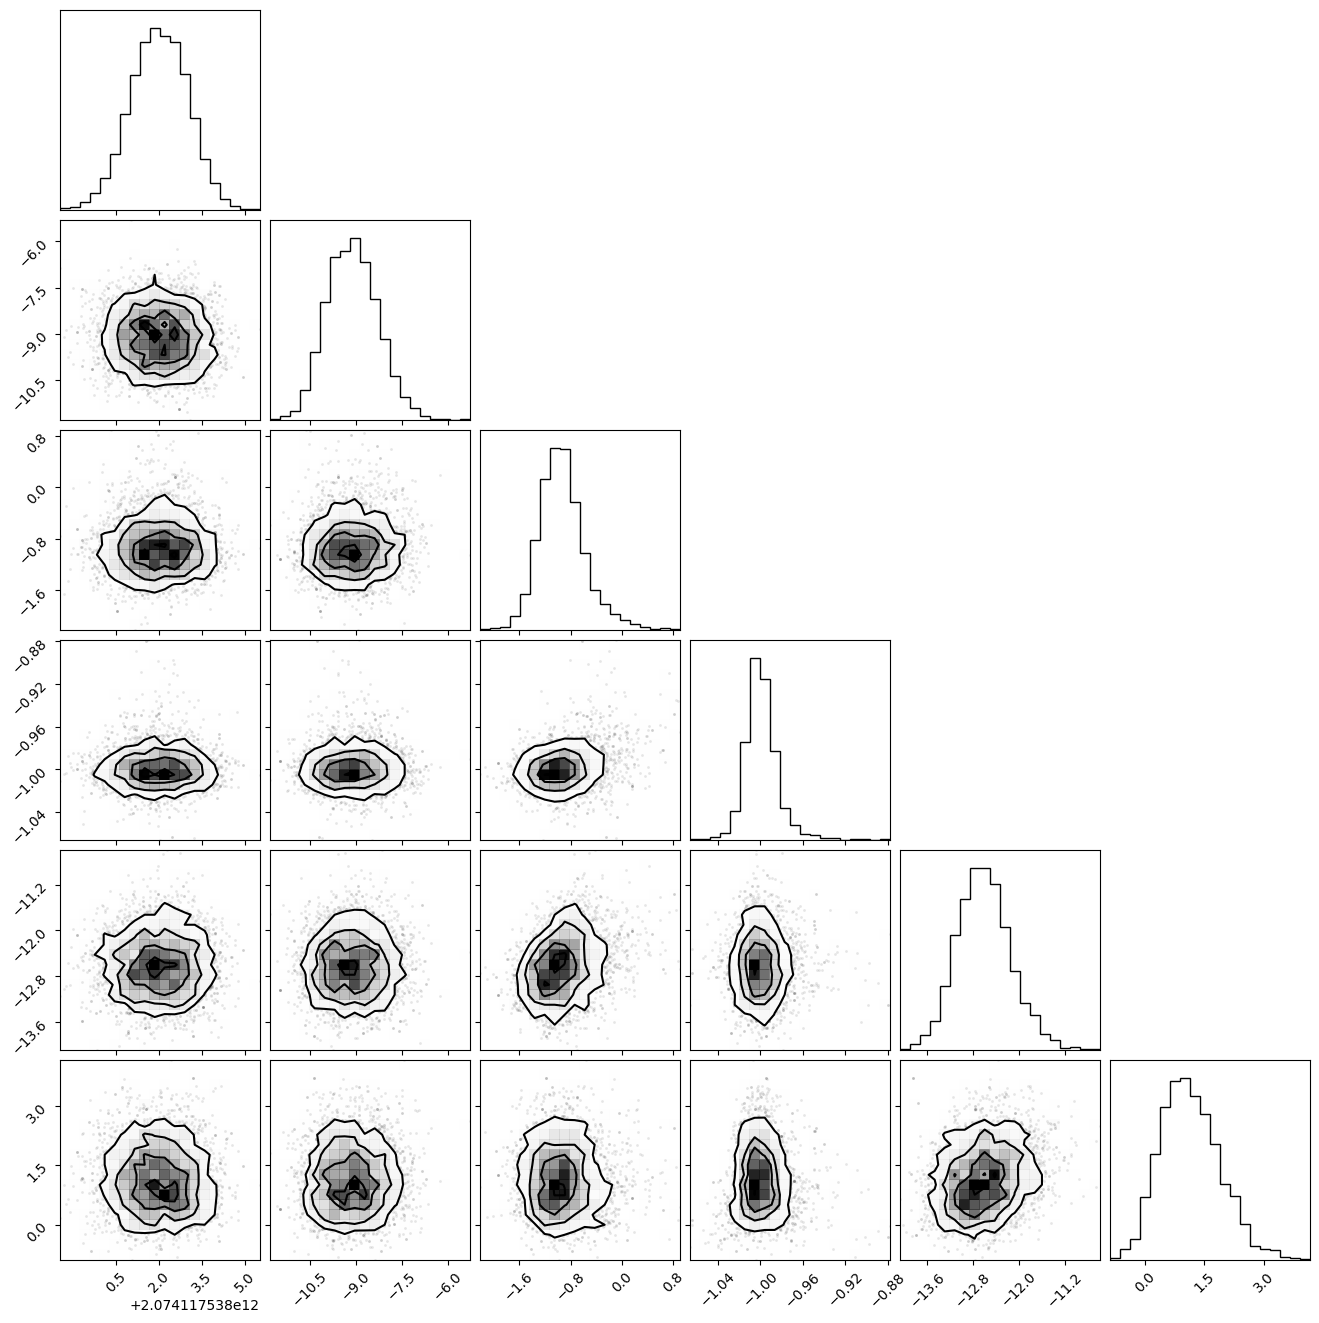

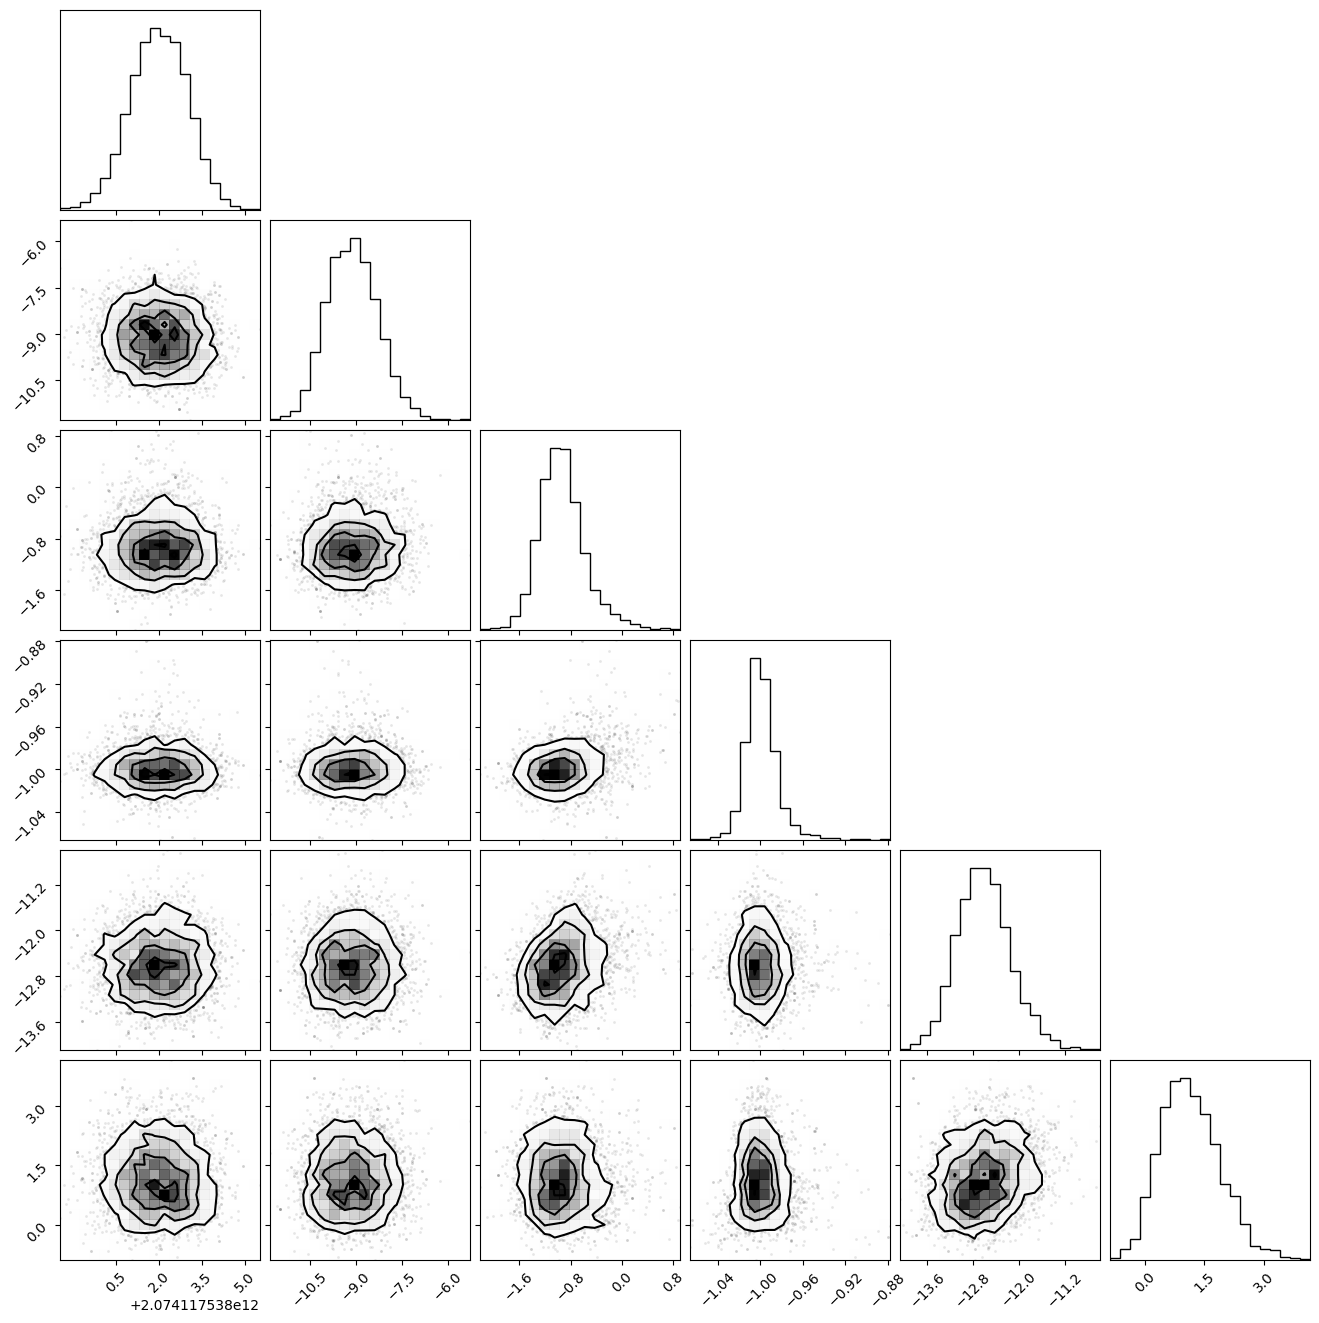

In [19]:
corner(np.array(state_history.position["gp_parameter"]))